## Parte B

In [4]:
# Abrimos un cliente de S3
import boto3
session = boto3.Session()
s3 = session.client('s3')

In [9]:
# Importamos awswrangler
import awswrangler as wr

Para el catálogo de frutas y legumbres...

NOTA: 
Se lee directo la tabla particionada para que no tener problemas con memoria ni tener queries costosos.

#### ¿De qué año a qué año tienen datos de esa categoría?

In [38]:
query = '''
    SELECT 
        MIN(EXTRACT(YEAR FROM fecharegistro)) AS ANIO_INICIAL,
        MAX(EXTRACT(YEAR FROM fecharegistro)) AS ANIO_FINAL
    FROM
        profeco_db.profeco;
'''

df = wr.athena.read_sql_query(
    query, 
    database="profeco_db",
    ctas_approach=False, 
    boto3_session=session
)

print(df)

   ANIO_INICIAL  ANIO_FINAL
0          2018        2024


#### ¿Cuántos registros de fecha hay vacíos?

In [37]:
query = '''
    SELECT
        COUNT(*)
    FROM
        profeco_db.profeco
    WHERE
        fecharegistro IS NULL;
'''

df = wr.athena.read_sql_query(
    query, 
    database="profeco_db",
    ctas_approach=False, 
    boto3_session=session
)

print(df)

   _col0
0      0


#### ¿Cuántos registros tienes por año?

In [36]:
query = '''
    SELECT
        EXTRACT(YEAR FROM fecharegistro) AS ANIO,
        COUNT(*) AS REGISTROS
    FROM
        profeco_db.profeco
    GROUP BY
        EXTRACT(YEAR FROM fecharegistro);
'''

df = wr.athena.read_sql_query(
    query, 
    database="profeco_db",
    ctas_approach=False, 
    boto3_session=session
)

print(df)

   ANIO  REGISTROS
0  2021     756850
1  2022     926031
2  2018     938616
3  2023     861829
4  2024     211839
5  2019     702747
6  2020     643820


#### ¿Cuál es el precio mínimo, máximo, promedio, desviación estándar, mediana, cuantil 25 y 75% de tu categoría por año?

In [39]:
query = '''
    SELECT
        EXTRACT(YEAR FROM fecharegistro) AS ANIO,
        MIN(precio) AS MINIMO,
        MAX(precio) AS MAXIMO,
        AVG(precio) AS PROMEDIO,
        STDDEV(precio) AS DESVIACION,
        APPROX_PERCENTILE(precio, 0.5) AS MEDIANA,
        APPROX_PERCENTILE(precio, 0.25) AS CUANTIL_25,
        APPROX_PERCENTILE(precio, 0.75) AS CUANTIL_75
    FROM
        profeco_db.profeco
    GROUP BY
        EXTRACT(YEAR FROM fecharegistro);
'''

df = wr.athena.read_sql_query(
    query, 
    database="profeco_db",
    ctas_approach=False, 
    boto3_session=session
)

print(df)

   ANIO  MINIMO  MAXIMO   PROMEDIO  DESVIACION    MEDIANA  CUANTIL_25  \
0  2019     1.9   380.0  31.656408   27.810392  24.004609   15.777440   
1  2020     1.0   350.0  33.395927   27.988478  25.804951   16.318612   
2  2021     2.0   470.0  36.047864   29.815307  27.435666   17.242742   
3  2022     1.9   479.0  40.779887   33.103581  31.538468   20.217637   
4  2023     2.0   543.5  42.970440   36.531773  33.823845   21.663103   
5  2018     1.9   440.0  29.267696   25.660128  21.946328   14.678832   
6  2024     3.0   480.0  46.141206   38.415075  37.636392   23.693595   

   CUANTIL_75  
0   38.808874  
1   40.145321  
2   45.110894  
3   50.448527  
4   51.930877  
5   36.065735  
6   54.833927  


#### ¿Cuáles son el top 5 de marcas con mayor precio en cada estado? ¿Verifica si te dió lo mismo en Spark?

In [44]:
query = '''
    SELECT 
        estado,
        producto,
        precio
    FROM
        (
            SELECT
                estado,
                producto,
                precio,
                ROW_NUMBER() OVER (PARTITION BY estado ORDER BY precio DESC) AS RN
            FROM
                profeco_db.profeco
        )
    WHERE
        RN <= 5;
'''

df = wr.athena.read_sql_query(
    query, 
    database="profeco_db",
    ctas_approach=False, 
    boto3_session=session
)

print(df)

              estado producto  precio
0            hidalgo  jamaica   329.0
1            hidalgo  jamaica   329.0
2            hidalgo  jamaica   329.0
3            hidalgo  jamaica   289.9
4            hidalgo  jamaica   289.9
..               ...      ...     ...
155  baja california  jamaica   399.9
156  baja california  jamaica   399.9
157  baja california  jamaica   399.9
158  baja california  jamaica   399.9
159  baja california  jamaica   399.9

[160 rows x 3 columns]


Al hacer varias pruebas, observamos que los datos son consistentes con lo que se obtuvo en Spark.

#### ¿Cuáles son el top 5 de marcas con menor precio en CDMX? (en aquel entonces Distrito Federal) ¿Verifica si te dió lo mismo en Spark?

In [45]:
query = '''
    SELECT 
        estado,
        producto,
        precio
    FROM
        (
            SELECT
                estado,
                producto,
                precio,
                ROW_NUMBER() OVER (PARTITION BY estado ORDER BY precio ASC) AS RN
            FROM
                profeco_db.profeco
        )
    WHERE
        RN <= 5 AND estado='ciudad de mexico';
'''

df = wr.athena.read_sql_query(
    query, 
    database="profeco_db",
    ctas_approach=False, 
    boto3_session=session
)

print(df)

             estado producto  precio
0  ciudad de mexico    elote     1.0
1  ciudad de mexico    elote     1.0
2  ciudad de mexico    elote     1.0
3  ciudad de mexico    elote     1.9
4  ciudad de mexico    elote     1.9


Los resultados obtenidos son los mismos que en Spark.

#### ¿Cuáles son el top 5 de marcas con mayores observaciones? ¿Se parecen a las de nivel por estado? ¿Verifica si te dió lo mismo en Spark?

In [46]:
query = '''
    SELECT 
        producto,
        COUNT(*) AS OBSERVACIONES
    FROM
        profeco_db.profeco
    GROUP BY
        producto
    ORDER BY
        OBSERVACIONES DESC
    LIMIT 5;
'''

df = wr.athena.read_sql_query(
    query, 
    database="profeco_db",
    ctas_approach=False, 
    boto3_session=session
)

print(df)

       producto  OBSERVACIONES
0  chile fresco         394568
1       manzana         273092
2       cebolla         179824
3       platano         177399
4         limon         165295


Es exactamente lo mismo que se obtuvo en Spark.

#### Genera un boxplot por año, para cada una de las top 5 marcas de tu categoría
Para esta gráfica usamos R. Podemos recrear la gráfica con este código: 

In [ ]:
ggplot(mas_observados_df,
       aes(x = Year,
           y = precio)) +
  geom_boxplot() +
  stat_summary(fun = mean, geom = "point",
               color = "darkblue",
               size = 2) +
  geom_line(aes(group = producto),
            stat = "summary",
            fun = mean,
            color = "cyan4",
            linetype = "dotted",
            linewidth = 1) +
  facet_grid(producto ~ .,
             scales = "free") +
  theme_minimal() +
  labs(title = "Precios de los productos más observados 
  (ordenados de mayor a menor)",
       x = "Año",
       y = "Precio")

![Screenshot 2024-04-26 234241.png](<attachment:Screenshot 2024-04-26 234241.png>)

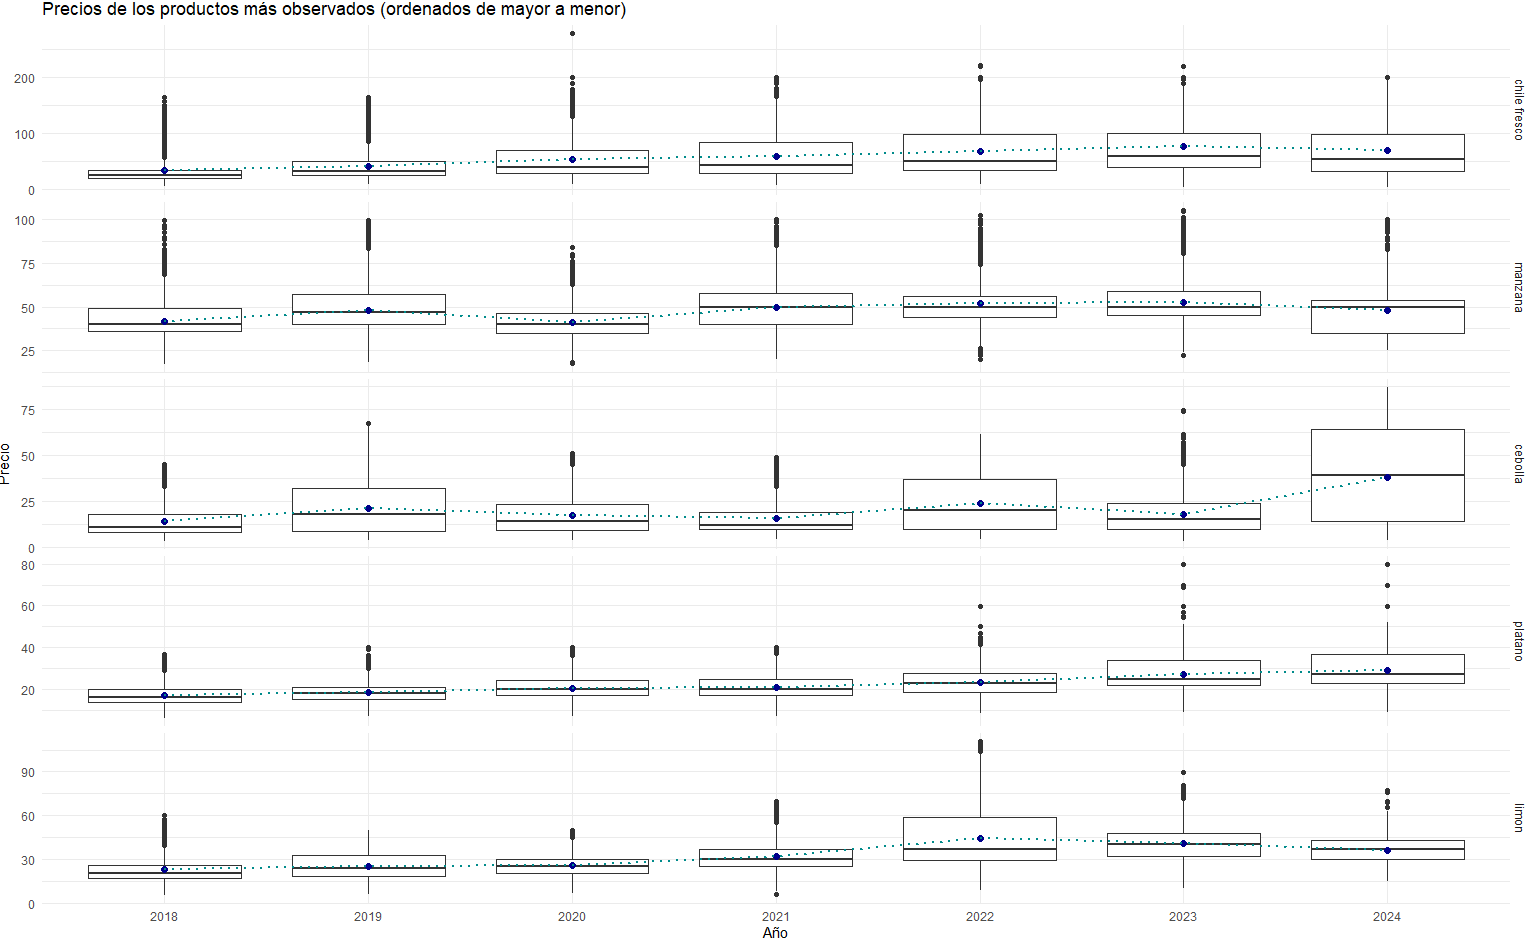